Setup covid dataset

In [1]:
import os
os.chdir('../')
import pandas as pd

In [2]:
df=pd.read_csv('data/covid_moonshot/activity_data.csv')
df.head()

,SMILES,CID,canonical_CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50,relative_solubility_at_20_uM,relative_solubility_at_100_uM,trypsin_IC50,NMR_std_ratio,acrylamide,chloroacetamide,series,frag_id
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,LUO-POS-e1dab717-11,NaN,NaN,NaN,NaN,NaN,0.275118,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,LUO-POS-e1dab717-12,NaN,NaN,NaN,NaN,NaN,0.202767,NaN,NaN,NaN,NaN,NaN,False,False,3-aminopyridine-like,NaN
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,MAT-POS-e48723dc-1,NaN,NaN,NaN,NaN,NaN,55.453947,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,MAT-POS-e48723dc-2,NaN,NaN,NaN,NaN,NaN,0.050000,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,LUO-POS-9931618f-2,NaN,NaN,NaN,NaN,NaN,0.052757,NaN,NaN,NaN,NaN,NaN,False,False,Ugi,NaN


In [3]:
df_actives_smiles=df[['SMILES','CID']][df['f_avg_IC50']<=5]
df_actives_smiles.head()
print(len(df_actives_smiles)/len(df)*100)

37.92434529582929


In [ ]:
df_actives_smiles.to_csv('data/covid_moonshot/actives_smiles.ism',index=False,sep=' ')
df_decoys_smiles=df[['SMILES','CID']][df['f_avg_IC50']>5]
df_decoys_smiles.to_csv('data/covid_moonshot/decoys_smiles.ism',index=False,sep=' ')

In [ ]:
import prody
import os

In [ ]:
pdb_dir='/home/rishal/pharmnn_rl/data/Mpro_XChem_screen_active_site_11-May-2020'
for file in os.listdir(pdb_dir):
    pdb=prody.parsePDB(pdb_dir+'/'+file)
    #remove water
    pdb=pdb.select('not water')
    #write out ligand to different pdb file
    ligand=pdb.select('resname LIG')
    prody.writePDB(pdb_dir+'/'+file.split('.pdb')[0]+'_lig.pdb',ligand)
    pdb=pdb.select('not resname LIG')
    prody.writePDB(pdb_dir+'/'+file.split('.pdb')[0]+'_nowat.pdb',pdb)

In [ ]:
from rdkit.Chem import AllChem
from rdkit import Chem

def fix_bond_order(template, pdb_ligand):
    #load molecule from template smiles
    template_mol=Chem.MolFromSmiles(template)
    #load molecule from pdb ligand
    pdb_ligand_mol=Chem.MolFromPDBFile(pdb_ligand)
    fixed_mol=AllChem.AssignBondOrdersFromTemplate(template_mol,pdb_ligand_mol)
    with Chem.SDWriter(pdb_ligand.split('.pdb')[0]+'_fixed.sdf') as w:
        w.write(fixed_mol)

In [ ]:
dataset_df=pd.read_excel('/home/rishal/pharmnn_rl/data/Mpro full XChem screen - hits summary - ver-2020-06-12.xlsx')
dataset_df.head()

In [ ]:
for file in os.listdir(pdb_dir):
    if file.endswith('lig.pdb'):
        mpro_id=file.split('_')[0]
        smiles=dataset_df['Compound SMILES'][dataset_df['Dataset']==mpro_id].values[0]
        try:
            fix_bond_order(smiles,pdb_dir+'/'+file)
        except:
            print(file)

In [ ]:
import openbabel as ob
from openbabel import pybel

In [ ]:

#infer aromaticity from molecules in sdf file
def infer_aromaticity(sdf_file):
    mol=pybel.readfile('sdf',sdf_file)
    for m in mol:
        m.write('sdf',sdf_file.split('.sdf')[0]+'_arom.sdf',overwrite=True)

In [ ]:
for file in os.listdir(pdb_dir):
    if file.endswith('fixed.sdf'):
        infer_aromaticity(pdb_dir+'/'+file)

Extract pharmacophores from all the ligand files

In [15]:
pdb_dir='/home/rishal/pharmnn_rl/data/Mpro_XChem_screen_active_site_11-May-2020'

In [ ]:

for file in os.listdir(pdb_dir):
    if file.endswith('arom.sdf'):
        os.system(pdb_dir+'/pharmit.2023 pharma -in '+pdb_dir+'/'+file+' -out '+pdb_dir+'/'+file.split('.sdf')[0]+'.json')

In [12]:
import json
import pandas as pd

In [17]:
def extract_json(json_file):
    """Takes a json files as input and returns a pandas dataframe with the headers as the keys of the json file"""
    with open(json_file) as f:
        data = json.load(f)
    data=data['points']
    df = pd.DataFrame(data)
    df=df[df['enabled']==True]
    return df

In [18]:
df_big=None
for file in os.listdir(pdb_dir):
    if file.endswith('fixed_arom_pharmit.json'):
        df=extract_json(pdb_dir+'/'+file)
        if df_big is None:
            df_big=df
        else:
            df_big=df_big.append(df)

/tmp/ipykernel_406364/3856936148.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3856936148.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3856936148.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3856936148.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3856936148.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/

In [48]:
print(df_big.tail())

   enabled              name  radius          x      y          z  size
0     True          Aromatic     1.0   9.530833 -1.109  23.749667   NaN
1     True       Hydrophobic     1.0   9.530833 -1.109  23.749667   NaN
2     True  HydrogenAcceptor     0.5   8.909000 -6.307  25.819000   NaN
3     True     HydrogenDonor     0.5   8.909000 -6.307  25.819000   NaN
4     True       Hydrophobic     1.0  10.807000  2.680  23.586000   NaN


Cluster extracted pharmacophore points

In [20]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

/home/rishal/.conda/envs/pharmnn/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [21]:
def cluster_xyz(feat_to_coords,distance_threshold=1.5):

    clustering = AgglomerativeClustering(n_clusters=None,compute_full_tree=True,linkage='average',distance_threshold=distance_threshold)
    for category in feat_to_coords.keys():
        if len(feat_to_coords[category])<2:
            continue
        final_xyz=[]
        coord_array=np.array(feat_to_coords[category])
        clustering.fit(coord_array)
        clusters=clustering.labels_
        for n in np.unique(clusters):
            cluster_center=coord_array[clusters==n].mean(axis=0)
            final_xyz.append(cluster_center)
        feat_to_coords[category]=final_xyz
    return feat_to_coords

In [22]:
def write_xyz(feat_to_coords,xyz_file_name,pdb_dir):
    for feat in feat_to_coords:
        with open(pdb_dir+'/'+feat+'_'+xyz_file_name,'w') as f:
            for coord in feat_to_coords[feat]:
                f.write('H '+str(coord[0])+' '+str(coord[1])+' '+str(coord[2])+'\n')

In [23]:
feat_to_coords={}
for feat,x,y,z in zip(df_big['name'],df_big['x'],df_big['y'],df_big['z']):
    if feat not in feat_to_coords.keys():
        feat_to_coords[feat]=[]
    coords=np.array([x,y,z])
    feat_to_coords[feat].append(coords)

In [24]:
write_xyz(feat_to_coords,'original_unclustered_enabled.xyz',pdb_dir)

In [25]:
print(feat_to_coords.keys())
print(len(feat_to_coords['Hydrophobic']))

dict_keys(['HydrogenAcceptor', 'Aromatic', 'Hydrophobic', 'HydrogenDonor'])
30


In [26]:
feat_to_coords=cluster_xyz(feat_to_coords,distance_threshold=1.5)
print(len(feat_to_coords['Aromatic']))

7


In [28]:
write_xyz(feat_to_coords,'original_clustered_enabled.xyz',pdb_dir)

In [29]:
print(len(feat_to_coords['Hydrophobic']))

14


In [14]:
pdb_dir='/home/rishal/pharmnn_rl/data/Mpro_XChem_screen_active_site_11-May-2020'

In [30]:

lines=[]
file_write=open('data/covid_moonshot_enabled.txt','w')
for file in os.listdir(pdb_dir):
    if 'json' in file:
        if 'query' in file:
            continue
        df=extract_json(pdb_dir+'/'+file)
        for name,x,y,z in zip(df['name'],df['x'],df['y'],df['z']):
            file_write.write(name+','+str(x)+','+str(y)+','+str(z)+','+file.split('.json')[0] + '.sdf,' +file.split('_lig')[0]+'_nowat.pdb'+'\n')

In [12]:
example_ligand='Mpro-x0354_0_lig_fixed_arom.sdf'
example_protein='Mpro-x0354_0_nowat.pdb'

In [15]:
def get_points_from_xyz(file):
    points=[]
    with open(file) as f:
        for line in f:
            points.append(line.split())
    return points

In [18]:
file_write=open('data/covid_moonshot_clustered_enabled.txt','w')
for file in os.listdir(pdb_dir):
    if "original_clustered_enabled.xyz" in file:
        feature=file.split('_')[0]
        points=get_points_from_xyz(pdb_dir+'/'+file)
        for point in points:
            file_write.write(feature+','+point[1]+','+point[2]+','+point[3]+','+example_ligand+','+example_protein+'\n')

Put clustered points into a single json file

In [19]:
file_with_points='data/covid_moonshot_clustered_enabled.txt'
df=pd.read_csv(file_with_points,header=None)
df.columns=['feature','x','y','z','ligand','protein']
df.head()

,feature,x,y,z,ligand,protein
0,HydrogenDonor,9.1225,-0.916,22.5115,Mpro-x0354_0_lig_fixed_arom.sdf,Mpro-x0354_0_nowat.pdb
1,HydrogenDonor,8.9090,-6.307,25.8190,Mpro-x0354_0_lig_fixed_arom.sdf,Mpro-x0354_0_nowat.pdb
2,HydrogenDonor,10.3530,1.571,24.3790,Mpro-x0354_0_lig_fixed_arom.sdf,Mpro-x0354_0_nowat.pdb
3,HydrogenDonor,9.3040,-4.215,27.8200,Mpro-x0354_0_lig_fixed_arom.sdf,Mpro-x0354_0_nowat.pdb
4,HydrogenDonor,9.3520,5.175,22.9550,Mpro-x0354_0_lig_fixed_arom.sdf,Mpro-x0354_0_nowat.pdb


In [20]:
print(len(df[df['feature']=='Hydrophobic']))

14


In [21]:
import json
json_file='data/covid_moonshot_clustered_enabled.json'
json_dict={}
json_dict['points']=[]
for row in df.iterrows():
    points_dict={}
    points_dict['name']=row[1]['feature']
    points_dict['x']=row[1]['x']
    points_dict['y']=row[1]['y']
    points_dict['z']=row[1]['z']
    points_dict['enabled']=True
    points_dict['radius']=1
    json_dict['points'].append(points_dict)

ligand=open('data/Mpro_XChem_screen_active_site_11-May-2020/'+ example_ligand).read()
protein=open('data/Mpro_XChem_screen_active_site_11-May-2020/'+example_protein).read()
json_dict['ligand']=ligand
json_dict['receptor']=protein
json_dict['recname']=example_protein
json_dict['ligname']=example_ligand
json_dict['ligandFormat']='sdf'
json.dump(json_dict,open(json_file,'w'))

Generate pharmacophore Queries

In [50]:
import json, sys, os
from itertools import combinations

def genqueries(fname):
    prefix,ext = os.path.splitext(fname)
    q = json.load(open(fname))
    features = [feat for feat in q['points'] if feat['enabled']]

    for i in range(3,len(features)+1):
        for j,combo in enumerate(combinations(features,i)):
            query = {"points": combo}
            json.dump(query, open(f'{prefix}_{i}_{j}_enabled.json','w'))

In [51]:
pdb_dir='/home/rishal/pharmnn_rl/data/Mpro_XChem_screen_active_site_11-May-2020'

for file in os.listdir(pdb_dir):
    if 'fixed_arom_pharmit.json' in file:
        if 'query' in file:
            continue
        genqueries(pdb_dir+'/'+file)

Setup Fresco benchmark

In [ ]:
import pandas as pd
df_activity =pd.read_csv('data/fresco_moonshot/covid_moonshot_activity_data.csv')
df_activity.tail()

In [ ]:
len(df_activity)

In [ ]:
df_dates=pd.read_csv('data/fresco_moonshot/covid_moonshot_submission_dates.csv')
df_dates.head()
len(df_dates)

In [ ]:

df_dates=df_dates.sort_values(by='date')
df_dates.head()

In [ ]:
df_dates=df_dates[df_dates['date']<=20200901]
print(len(df_dates))

In [ ]:
df_dates=df_dates[df_dates['year']<=2020]
print(len(df_dates))

In [ ]:
df_dates=df_dates[df_dates['month']<=9]
print(len(df_dates))

In [ ]:
print(df_dates.head())
print(df_dates.tail())

In [ ]:
df_activity.head()
df_activity['canonical_CID']=df_activity['canonical_CID'].apply(lambda x: '-'.join(x.split('-')[:-1]))
df_activity.head()


In [ ]:
print(df_dates.head())

In [ ]:
df_activity_final=None
for submission in df_dates['submission_id']:
    df_temp=df_activity[df_activity['canonical_CID'].str.contains(submission)]
    if df_activity_final is None:
        df_activity_final=df_temp
    else:
        df_activity_final=df_activity_final.append(df_temp)

In [ ]:
df_activity_final.head()

In [ ]:
len(df_activity_final)

In [ ]:
print(len(df_activity_final[df_activity_final['f_avg_IC50']<=0.5]))

In [ ]:
print(df_activity_final[df_activity_final['canonical_CID']=='DAR-DIA-23aa0b97'])

In [ ]:
from rdkit.Chem import PandasTools

sdfFile = 'data/fresco_moonshot/covid_moonshot_docked_mols.sdf'
df_docking = PandasTools.LoadSDF(
    sdfFile, idName='canonical_CID', smilesName='SMILES', molColName='mol')

In [ ]:
from distutils.util import strtobool
df_docking = df_docking.dropna(subset=['acrylamide'])
df_docking['acrylamide'] = df_docking['acrylamide'].apply(
    strtobool).astype(bool)
df_docking['chloroacetamide'] = df_docking['chloroacetamide'].apply(
    strtobool).astype(bool)

df_docking = df_docking.query('~chloroacetamide & ~acrylamide').reset_index()
df_docking

In [ ]:

df_docking.f_avg_IC50 = df_docking.f_avg_IC50.astype(float)
df_docking['Chemgauss4 Score'] = df_docking['Chemgauss4 Score'].astype(float)

columns_to_keep = ['canonical_CID', 'Chemgauss4 Score', 'f_avg_IC50','SMILES']
df_docking = df_docking[columns_to_keep]
df_docking_grouped = df_docking.groupby(by=df_docking.canonical_CID)
df_docking_grouped = df_docking_grouped.agg({'SMILES':'first', 'Chemgauss4 Score':'mean', 'f_avg_IC50':'mean'})
df_docking_grouped['canonical_CID'] = df_docking_grouped.index

df_docking_grouped['hit'] = df_docking_grouped['f_avg_IC50'] < 5

In [ ]:
print(len(df_docking_grouped[df_docking_grouped['hit'] == True]))

In [ ]:
print(len(df_docking_grouped))

In [ ]:
print(df_docking_grouped.head())

In [ ]:
def remove_suffix(id):
    id_separated = id.split('-')[:-1]
    new_id = '-'.join(id_separated)
    return new_id
df_docking_grouped['submission_id'] = df_docking_grouped['canonical_CID'].apply(remove_suffix)
df_merged = df_docking_grouped.merge(df_dates, on='submission_id')
df_merged['Neg Dock Score'] = df_merged['Chemgauss4 Score']*-1

In [ ]:
print(len(df_docking_grouped))

In [ ]:
print(df_merged.head())
print(df_merged.tail())

In [ ]:
df_merged.sort_values(by='date', ascending=False).head()

In [ ]:
print(len(df_merged))

In [ ]:
year = '2020'
month = '09'
day = '01'
date_to_plot = int(f'{year}{month}{day}')
ic50_threshold = 5

#df_filtered_by_date = df_merged.query('date < @date_to_plot').copy()
df_filtered_by_date=df_merged[df_merged['date']<20200901]
df_filtered_by_date['hit'] = df_filtered_by_date['f_avg_IC50'] < ic50_threshold
print(len(df_filtered_by_date))

In [ ]:
print(len(df_filtered_by_date[df_filtered_by_date['hit'] == True]))

In [ ]:
df_actives=df_filtered_by_date[df_filtered_by_date['hit'] == True]
df_actives.head()

In [ ]:
df_actives=df_actives[['SMILES','canonical_CID']]
df_actives.head()

In [ ]:
df_actives.to_csv('data/fresco_moonshot/actives_smiles.ism',index=False,sep=' ')

In [ ]:
df_decoys=df_filtered_by_date[df_filtered_by_date['hit'] == False]
df_decoys=df_decoys[['SMILES','canonical_CID']]
df_decoys.to_csv('data/fresco_moonshot/decoys_smiles.ism',index=False,sep=' ')

Evaluate generated pharmacophores

In [53]:
import subprocess
import pandas as pd
systems=[]
for file in os.listdir(pdb_dir):
    system=file.split('_')[0]
    if system not in systems:
        systems.append(system)
        scores={}
        for file in os.listdir(pdb_dir):
            if system in file:
                if '_enabled.json' in file and 'clustered' not in file:
                    output=subprocess.check_output('python getf1.py '+pdb_dir+'/'+file+' data/covid_moonshot/covid_moonshot/ --actives data/covid_moonshot/actives_smiles.ism --decoys data/covid_moonshot/decoys_smiles.ism',shell=True)
                    output=output.decode()
                    output=output.split(' ')
                    f1=output[1]
                    scores[file]=f1   
            else:
                continue
        df=pd.DataFrame.from_dict(scores,orient='index')
        df.to_csv(pdb_dir+'/'+system+'_enabled_scores.csv')
        print(system)
    else:
        continue

Mpro-x1077
Mpro-x0434
pharmit
Mpro-x0967
Mpro-x1093
Mpro-x0395
Mpro-x0104
query
Mpro-x0397
Mpro-x0195
Mpro-x0946
Mpro-x0161
Mpro-x0107
Mpro-x0874
Mpro-x0354
Mpro-x0995
Mpro-x0305
HydrogenDonor
Mpro-x0540
Mpro-x0426
Mpro-x2193
Mpro-x1249
Mpro-x0678
Mpro-x0387
Mpro-x0072
pharmit.2023
hydrogen.pdb
HydrogenAcceptor
Mpro-x0991
Hydrophobic
Aromatic
query.json


In [58]:
import os
import pandas as pd
pdb_dir='/home/rishal/pharmnn_rl/data/Mpro_XChem_screen_active_site_11-May-2020'
df_big=None
for file in os.listdir(pdb_dir):
    if "_enabled_scores.csv" in file and 'fresco' not in file:
        df=pd.read_csv(pdb_dir+'/'+file)
        try:
            df=df.sort_values(by='0',ascending=False)
        except:
            continue
        if df_big is None:
            df_big=df
        else:
            df_big=df_big.append(df)
print(df_big.head())
print(df_big['0'].max())

/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)


                                          Unnamed: 0         0
1  Mpro-x0354_0_lig_fixed_arom_pharmit_3_0_enable...  0.585920
2  Mpro-x0354_0_lig_fixed_arom_pharmit_3_1_enable...  0.577396
3  Mpro-x0354_0_lig_fixed_arom_pharmit_3_3_enable...  0.555771
0  Mpro-x0354_0_lig_fixed_arom_pharmit_4_0_enable...  0.539837
4  Mpro-x0354_0_lig_fixed_arom_pharmit_3_2_enable...  0.539037
0.643917


/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/3317182660.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)


In [59]:
import subprocess
import pandas as pd
systems=[]
for file in os.listdir(pdb_dir):
    system=file.split('_')[0]
    if system not in systems:
        systems.append(system)
        scores={}
        for file in os.listdir(pdb_dir):
            if system in file:
                if '_enabled.json' in file and 'clustered' not in file:
                    output=subprocess.check_output('python getf1.py '+pdb_dir+'/'+file+' data/fresco_moonshot/fresco_moonshot/ --actives data/fresco_moonshot/actives_smiles.ism --decoys data/fresco_moonshot/decoys_smiles.ism',shell=True)
                    output=output.decode()
                    output=output.split(' ')
                    f1=output[1]
                    scores[file]=f1   
            else:
                continue
        df=pd.DataFrame.from_dict(scores,orient='index')
        df.to_csv(pdb_dir+'/'+system+'fresco_enabled_scores.csv')
        print(system)
    else:
        continue

Mpro-x1077
Mpro-x0434
pharmit
Mpro-x0967
Mpro-x1093
Mpro-x0395
Mpro-x0104
query
Mpro-x0397
Mpro-x0195
Mpro-x0946
Mpro-x0161
Mpro-x0107
Aromatic
Mpro-x0874
Mpro-x0354
Mpro-x0995
Mpro-x0305
HydrogenDonor
Mpro-x0540
Mpro-x0426
Mpro-x2193
Mpro-x1249
Mpro-x0678
Mpro-x0387
Mpro-x0072
pharmit.2023
hydrogen.pdb
HydrogenAcceptor
Mpro-x0991
Hydrophobic
query.json


In [60]:
import os
import pandas as pd
pdb_dir='/home/rishal/pharmnn_rl/data/Mpro_XChem_screen_active_site_11-May-2020'
df_big=None
for file in os.listdir(pdb_dir):
    if "fresco_enabled_scores.csv" in file:
        df=pd.read_csv(pdb_dir+'/'+file)
        try:
            df=df.sort_values(by='0',ascending=False)
        except:
            continue
        if df_big is None:
            df_big=df
        else:
            df_big=df_big.append(df)
print(df_big.head())
print(df_big['0'].max())

                                          Unnamed: 0         0
3  Mpro-x1093_0_lig_fixed_arom_pharmit_3_0_enable...  0.120000
1  Mpro-x1093_0_lig_fixed_arom_pharmit_3_3_enable...  0.116486
0  Mpro-x1093_0_lig_fixed_arom_pharmit_3_1_enable...  0.104110
2  Mpro-x1093_0_lig_fixed_arom_pharmit_3_2_enable...  0.098701
4  Mpro-x1093_0_lig_fixed_arom_pharmit_4_0_enable...  0.088154
0.175


/tmp/ipykernel_406364/868032147.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/868032147.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/868032147.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/868032147.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/ipykernel_406364/868032147.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_big=df_big.append(df)
/tmp/

In [64]:
def lines_to_pharmit_query(lines,pdb_file):
    query = {}
    query['points'] = []
    for line in lines:
        line = line.split(',')
        point = {}
        point['name'] = line[0]
        point['x'] = float(line[1])
        point['y'] = float(line[2])
        point['z'] = float(line[3])
        query['points'].append(point)
    #query["exselect"] = "receptor"
    #query["extolerance"] = 1
    #query["recname"] = line[5]
    #query["receptor"] = pdb_file
    return query

In [65]:
import random
import os
import subprocess
import json
file = open('data/covid_moonshot_enabled.txt','r')
pdb_file=open('data/Mpro_XChem_screen_active_site_11-May-2020/Mpro-x0072_0_nowat.pdb','r').readlines()
pdb_file="".join(pdb_file)
lines = file.readlines()

pharmacophore_lengths=[3,4,5]
covid_f1s=[]
fresco_f1s=[]
for i in range(10000):
    if i%100==0:
        print(i)
    pharm_len=random.choice(pharmacophore_lengths)
    random_lines=random.sample(lines, pharm_len)
    query=lines_to_pharmit_query(random_lines,pdb_file)
    with open('data/covid_moonshot_cnn_clustered_test_query.json','w') as f:
        json.dump(query,f)
    output=subprocess.check_output('python getf1.py data/covid_moonshot_cnn_clustered_test_query.json data/covid_moonshot/covid_moonshot/ --actives data/covid_moonshot/actives_smiles.ism --decoys data/covid_moonshot/decoys_smiles.ism',shell=True)
    output=output.decode()
    output=output.split(' ')
    covid_f1=output[1]
    covid_f1s.append(covid_f1)
    output=subprocess.check_output('python getf1.py data/covid_moonshot_cnn_clustered_test_query.json data/fresco_moonshot/fresco_moonshot/ --actives data/fresco_moonshot/actives_smiles.ism --decoys data/covid_moonshot/decoys_smiles.ism',shell=True)
    output=output.decode()
    output=output.split(' ')
    fresco_f1=output[1]
    fresco_f1s.append(fresco_f1)
print(np.mean(covid_f1s))
print(np.mean(fresco_f1s))
    


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U8'), dtype('<U8')) -> None

In [66]:
covid_f1s=[float(i) for i in covid_f1s]
fresco_f1s=[float(i) for i in fresco_f1s]
covid_f1s=np.array(covid_f1s)
fresco_f1s=np.array(fresco_f1s)
print(np.mean(covid_f1s))
print(np.mean(fresco_f1s))

0.010905257799999998
0.004909029800000001


In [67]:
print(np.max(covid_f1s))
print(np.max(fresco_f1s))

0.636595
0.207547


Get pharmnn_rl predictions and results

In [3]:
import os
os.chdir('../')
import subprocess


In [2]:
os.system('python predict.py --input_json data/covid_moonshot_clustered_enabled.json --features ligand_only --output_prefix data/covid_fragments_pharmacophore_min_3 --min_features 3')
os.system('python predict.py --input_json data/covid_moonshot_clustered_enabled.json --features ligand_only --output_prefix data/covid_fragments_pharmacophore_min_4 --min_features 4')
os.system('python predict.py --receptor data/Mpro_XChem_screen_active_site_11-May-2020/Mpro-x0354_0_nowat.pdb --ligand data/Mpro_XChem_screen_active_site_11-May-2020/Mpro-x0354_0_lig_fixed_arom.sdf --features cnn_only --output_prefix data/covid_cnn_pharmacophore_min_3 --min_features 3 --autobox_extend 4')
os.system('python predict.py --receptor data/Mpro_XChem_screen_active_site_11-May-2020/Mpro-x0354_0_nowat.pdb --ligand data/Mpro_XChem_screen_active_site_11-May-2020/Mpro-x0354_0_lig_fixed_arom.sdf --features cnn_only --output_prefix data/covid_cnn_pharmacophore_min_4 --min_features 4 --autobox_extend 4')

/home/rishal/.conda/envs/pharmnn/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home/rishal/pharmnn_rl/Pharmnn/dataset.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Cluster']=clustering.labels_
/home/rishal/pharmnn_rl/Pharmnn/dataset.py:316: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df_subset_new=df_subset.groupby('Cluster').mean(numeric_

0

In [31]:
import numpy as np
import pandas as pd

df=pd.DataFrame(columns=['system','num_feats','model','precision','recall','f1','enrichment','hit_rate','features'])
num_feats=[3,4]
prefixes=['covid_fragments_pharmacophore_min_','covid_cnn_pharmacophore_min_']
for prefix in prefixes:
    if 'fragments' in prefix:
        pharm_features='fragments'
    else:
        pharm_features='cnn'
    for feat in num_feats:
        model_list=[]
        # if 'fragments' in prefix:
        #     model_list.append('model_ligand')
        model_list+=['model_cnn_1','model_cnn_2','model_cnn_3','model_cnn_4','model_cnn_5']
        for model in model_list:
            pharmacophore_file='data/'+prefix+str(feat)+'_'+model+'_predicted_pharmacophores.json'
            print(pharmacophore_file)
            output=subprocess.check_output('python getf1.py '+pharmacophore_file+ ' data/fresco_moonshot/fresco_moonshot  --actives data/fresco_moonshot/actives_smiles.ism --decoys data/fresco_moonshot/decoys_smiles.ism ' ,shell=True)
            output=output.decode('utf-8')
            results=output.split()
            f1=float(results[1])
            recall=float(results[3])
            precision=float(results[5])
            hit_rate=float(results[8])
            enrichment=float(results[11])
            df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
            output=subprocess.check_output('python getf1.py '+pharmacophore_file+ ' data/covid_moonshot/covid_moonshot  --actives data/covid_moonshot/actives_smiles.ism --decoys data/covid_moonshot/decoys_smiles.ism ' ,shell=True)
            output=output.decode('utf-8')
            results=output.split()
            f1=float(results[1])
            recall=float(results[3])
            precision=float(results[5])
            hit_rate=float(results[8])
            enrichment=float(results[11])
            df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
        

data/covid_fragments_pharmacophore_min_3_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':

data/covid_fragments_pharmacophore_min_3_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_1501840/3113971103.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_1501840/3113971103.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


# Table time

In [32]:
#
print(df.dtypes)
dtypes={'system':'object','model':'object','num_feats':int,'precision':float,'recall':float,'f1':float,'enrichment':float,'hit_rate':float,'features':'object'}
df=df.astype(dtypes)
df.loc[df['system']=='covid','system']='Full dataset'
df.loc[df['system']=='fresco','system']='Hit-to-lead'
df.set_index(['system','model','num_feats'],inplace=True)
df.sort_index(inplace=True)
df_fragments=df[df['features']=='fragments']
df_fragments.drop(columns='features',inplace=True)
df_cnn=df[df['features']=='cnn']
df_cnn.drop(columns='features',inplace=True)
print(df_fragments.to_latex(index=True,float_format="%.3f"))

system        object
num_feats     object
model         object
precision     object
recall        object
f1            object
enrichment    object
hit_rate      object
features      object
dtype: object
\begin{tabular}{lllrrrrr}
\toprule
            &             &   &  precision &  recall &    f1 &  enrichment &  hit\_rate \\
system & model & num\_feats &            &         &       &             &           \\
\midrule
Full dataset & model\_cnn\_1 & 3 &      0.451 &   0.950 & 0.612 &       1.110 &     0.856 \\
            &             & 4 &      0.451 &   0.950 & 0.612 &       1.110 &     0.856 \\
            & model\_cnn\_2 & 3 &      0.425 &   0.908 & 0.579 &       1.046 &     0.868 \\
            &             & 4 &      0.296 &   0.097 & 0.146 &       0.728 &     0.133 \\
            & model\_cnn\_3 & 3 &      0.299 &   0.055 & 0.093 &       0.735 &     0.075 \\
            &             & 4 &      0.299 &   0.055 & 0.093 &       0.735 &     0.075 \\
            & model\_cnn\_4

/tmp/ipykernel_1501840/832569923.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fragments.drop(columns='features',inplace=True)
/tmp/ipykernel_1501840/832569923.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cnn.drop(columns='features',inplace=True)
/tmp/ipykernel_1501840/832569923.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_fr

In [33]:
print(df_cnn.to_latex(index=True,float_format="%.3f"))

\begin{tabular}{lllrrrrr}
\toprule
            &             &   &  precision &  recall &    f1 &  enrichment &  hit\_rate \\
system & model & num\_feats &            &         &       &             &           \\
\midrule
Full dataset & model\_cnn\_1 & 3 &      0.551 &   0.271 & 0.363 &       1.356 &     0.200 \\
            &             & 4 &      0.118 &   0.003 & 0.005 &       0.290 &     0.009 \\
            & model\_cnn\_2 & 3 &      0.372 &   0.119 & 0.180 &       0.916 &     0.130 \\
            &             & 4 &      0.086 &   0.004 & 0.007 &       0.211 &     0.018 \\
            & model\_cnn\_3 & 3 &      0.239 &   0.070 & 0.109 &       0.589 &     0.119 \\
            &             & 4 &      0.000 &   0.000 & 0.000 &       0.000 &     0.000 \\
            & model\_cnn\_4 & 3 &      0.589 &   0.275 & 0.375 &       1.450 &     0.189 \\
            &             & 4 &      0.589 &   0.275 & 0.375 &       1.450 &     0.189 \\
            & model\_cnn\_5 & 3 &      0.422 &  

/tmp/ipykernel_1501840/2799306820.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_cnn.to_latex(index=True,float_format="%.3f"))


# f1 plots

In [84]:
import numpy as np
import pandas as pd
import subprocess
import matplotlib
import matplotlib.pyplot as plt

df=pd.DataFrame(columns=['system','num_feats','model','precision','recall','f1','enrichment','hit_rate','features'])
num_feats=[3,4]
prefixes=['covid_fragments_pharmacophore_min_','covid_cnn_pharmacophore_min_']
for prefix in prefixes:
    if 'fragments' in prefix:
        pharm_features='fragments'
    else:
        pharm_features='cnn'
    for feat in num_feats:
        model_list=[]
        # if 'fragments' in prefix:
        #     model_list.append('model_ligand')
        model_list+=['model_cnn_1','model_cnn_2','model_cnn_3','model_cnn_4','model_cnn_5']
        for model in model_list:
            pharmacophore_file='data/'+prefix+str(feat)+'_'+model+'_predicted_pharmacophores.json'
            print(pharmacophore_file)
            output=subprocess.check_output('python getf1.py '+pharmacophore_file+ ' data/fresco_moonshot/fresco_moonshot  --actives data/fresco_moonshot/actives_smiles.ism --decoys data/fresco_moonshot/decoys_smiles.ism ' ,shell=True)
            output=output.decode('utf-8')
            results=output.split()
            f1=float(results[1])
            recall=float(results[3])
            precision=float(results[5])
            hit_rate=float(results[8])
            enrichment=float(results[11])
            df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
            output=subprocess.check_output('python getf1.py '+pharmacophore_file+ ' data/covid_moonshot/covid_moonshot  --actives data/covid_moonshot/actives_smiles.ism --decoys data/covid_moonshot/decoys_smiles.ism ' ,shell=True)
            output=output.decode('utf-8')
            results=output.split()
            f1=float(results[1])
            recall=float(results[3])
            precision=float(results[5])
            hit_rate=float(results[8])
            enrichment=float(results[11])
            df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
        

data/covid_fragments_pharmacophore_min_3_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':pre

data/covid_fragments_pharmacophore_min_3_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':pre

data/covid_fragments_pharmacophore_min_4_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':pre

data/covid_cnn_pharmacophore_min_4_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/202681293.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/202681293.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


In [85]:
df=pd.concat([df,pd.DataFrame({'system':['fresco','fresco','covid','covid','fresco','fresco','covid','covid'],'f1':[0.010905257799999998,0.207547,0.004909029800000001,0.636595,0.010905257799999998,0.207547,0.004909029800000001,0.636595],'model':['Fragment_mean','Fragment_max','Fragment_mean','Fragment_max','Fragment_mean','Fragment_max','Fragment_mean','Fragment_max'],'features':['fragments','fragments','fragments','fragments','cnn','cnn','cnn','cnn']})],ignore_index=True)

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

In [87]:
#df.loc[df.model.str.contains('model_cnn'),'model']='PharmRL_CNN'
df.loc[df.model.str.contains('model_cnn'),'model']=df.loc[df.model.str.contains('model_cnn'),'model'].str.replace('model_cnn_','PharmRL_CNN_')
print(df)
df.loc[df.system=='fresco','system']='Hit-to-lead'
df.loc[df.system=='covid','system']='Full Dataset'
df_fresco=df[df['system']=='fresco']
df_fresco_fragment=df_fresco[df_fresco['features']=='fragments']
df_fresco_cnn=df_fresco[df_fresco['features']=='cnn']
df_covid=df[df['system']=='covid']
df_covid_fragment=df_covid[df_covid['features']=='fragments']
df_covid_cnn=df_covid[df_covid['features']=='cnn']
df_fragments=df[df['features']=='fragments']
df_cnn=df[df['features']=='cnn']

    system num_feats          model precision    recall        f1 enrichment  \
0   fresco         3  PharmRL_CNN_1  0.083779  0.783333  0.151369   1.369786   
1    covid         3  PharmRL_CNN_1  0.450909  0.950192  0.611591   1.110284   
2   fresco         3  PharmRL_CNN_2  0.076246  0.866667  0.140162   1.246628   
3    covid         3  PharmRL_CNN_2  0.424985  0.908046   0.57899   1.046451   
4   fresco         3  PharmRL_CNN_3  0.067797  0.133333  0.089888   1.108475   
5    covid         3  PharmRL_CNN_3  0.298611  0.054917  0.092772   0.735277   
6   fresco         3  PharmRL_CNN_4  0.071749  0.266667  0.113074   1.173094   
7    covid         3  PharmRL_CNN_4  0.377285  0.369093  0.373144   0.928997   
8   fresco         3  PharmRL_CNN_5       0.0       0.0       0.0        0.0   
9    covid         3  PharmRL_CNN_5       0.0       0.0       0.0        0.0   
10  fresco         4  PharmRL_CNN_1  0.083779  0.783333  0.151369   1.369786   
11   covid         4  PharmRL_CNN_1  0.4

[Text(0.5, 0, '')]

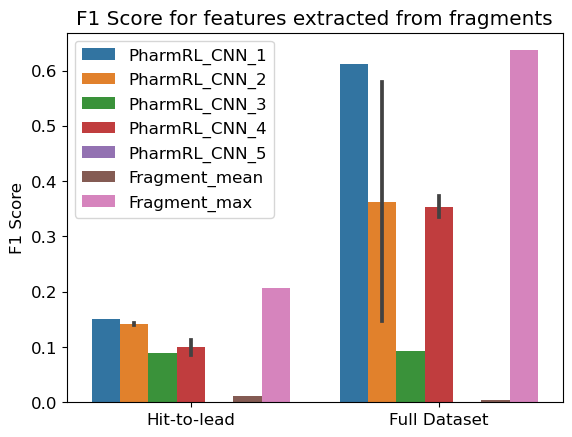

In [88]:
ax = sns.barplot(x="system", y="f1", hue="model", data=df_fragments)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score for features extracted from fragments')
ax.set(xlabel=None)

/tmp/ipykernel_2846682/2135741555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fragments.loc[df_fragments.model.str.contains('PharmRL_CNN'),'model']='PharmRL_CNN'


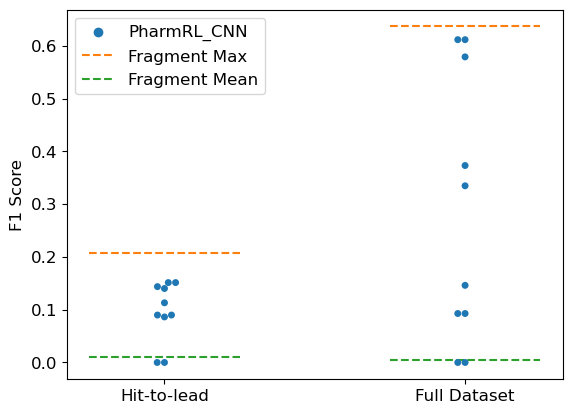

In [89]:
matplotlib.rcParams.update({'font.size': 12})
df_fragments.loc[df_fragments.model.str.contains('PharmRL_CNN'),'model']='PharmRL_CNN'
#df_cnn.loc[df_cnn.num_feats==3,'model']='PharmRL_CNN_3'
#ax=sns.boxplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn.model.str.contains('PharmRL_CNN')])
ax=sns.swarmplot(x='system',y='f1',hue='model',data=df_fragments[df_fragments.model.str.contains('PharmRL_CNN')])

#ax=sns.boxplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn['model']=='Fragment_mean'])
#ax=sns.boxplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn['model']=='Fragment_max'])
df_fragments_hit=df_fragments[df_fragments['system']=='Hit-to-lead']
df_fragments_full=df_fragments[df_fragments['system']=='Full Dataset']
#plot horizontal lines for mean and max for each system
ax.hlines(y=df_fragments_hit[df_fragments_hit['model']=='Fragment_max']['f1'],xmin=-0.25,xmax=0.25,linestyles='dashed',label='Fragment Max',color='#ff7f0e')
ax.hlines(y=df_fragments_full[df_fragments_full['model']=='Fragment_max']['f1'],xmin=0.75,xmax=1.25,linestyles='dashed',label='Fragment Max',color='#ff7f0e')
ax.hlines(y=df_fragments_hit[df_fragments_hit['model']=='Fragment_mean']['f1'],xmin=-0.25,xmax=0.25,linestyles='dashed',label='Fragment Mean',color='#2ca02c')
ax.hlines(y=df_fragments_full[df_fragments_full['model']=='Fragment_mean']['f1'],xmin=0.75,xmax=1.25,linestyles='dashed',label='Fragment Mean',color='#2ca02c')

#ax.hlines(y=df_cnn_hit[df_cnn_hit['model']=='Fragment_mean']['f1'],xmin=0,xmax=1,linestyles='dashed',label='Fragment Mean',color='red')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:2]+[handles[3]], labels=labels[:2]+[labels[3]])
ax.set_ylabel('F1 Score')
ax.set(xlabel=None)
plt.savefig('covid_f1_fragments.png',bbox_inches='tight')

In [90]:
import numpy as np
import pandas as pd

df=pd.DataFrame(columns=['system','num_feats','model','precision','recall','f1','enrichment','hit_rate','features'])
num_feats=[3,4]
prefixes=['covid_fragments_pharmacophore_min_','covid_cnn_pharmacophore_min_']
for prefix in prefixes:
    if 'fragments' in prefix:
        pharm_features='fragments'
    else:
        pharm_features='cnn'
    for feat in num_feats:
        model_list=[]
        if 'fragments' in prefix:
            model_list.append('model_ligand')
        model_list+=['model_cnn_1','model_cnn_2','model_cnn_3','model_cnn_4','model_cnn_5']
        for model in model_list:
            pharmacophore_file='data/'+prefix+str(feat)+'_'+model+'_predicted_pharmacophores.json'
            print(pharmacophore_file)
            output=subprocess.check_output('python getf1.py '+pharmacophore_file+ ' data/fresco_moonshot/fresco_moonshot  --actives data/fresco_moonshot/actives_smiles.ism --decoys data/fresco_moonshot/decoys_smiles.ism ' ,shell=True)
            output=output.decode('utf-8')
            results=output.split()
            f1=float(results[1])
            recall=float(results[3])
            precision=float(results[5])
            hit_rate=float(results[8])
            enrichment=float(results[11])
            df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
            output=subprocess.check_output('python getf1.py '+pharmacophore_file+ ' data/covid_moonshot/covid_moonshot  --actives data/covid_moonshot/actives_smiles.ism --decoys data/covid_moonshot/decoys_smiles.ism ' ,shell=True)
            output=output.decode('utf-8')
            results=output.split()
            f1=float(results[1])
            recall=float(results[3])
            precision=float(results[5])
            hit_rate=float(results[8])
            enrichment=float(results[11])
            df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
        

data/covid_fragments_pharmacophore_min_3_model_ligand_predicted_pharmacophores.json
data/covid_fragments_pharmacophore_min_3_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':

data/covid_fragments_pharmacophore_min_3_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_3_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':

data/covid_fragments_pharmacophore_min_4_model_ligand_predicted_pharmacophores.json
data/covid_fragments_pharmacophore_min_4_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':

data/covid_fragments_pharmacophore_min_4_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_fragments_pharmacophore_min_4_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_3_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':

data/covid_cnn_pharmacophore_min_4_model_cnn_1_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_2_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_3_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_4_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


data/covid_cnn_pharmacophore_min_4_model_cnn_5_predicted_pharmacophores.json


/tmp/ipykernel_2846682/1435562439.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'fresco','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)
/tmp/ipykernel_2846682/1435562439.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append({'system':'covid','num_feats':feat,'model':model,'precision':precision,'recall':recall,'f1':f1,'enrichment':enrichment,'hit_rate':hit_rate,'features':pharm_features},ignore_index=True)


[Text(0.5, 0, '')]

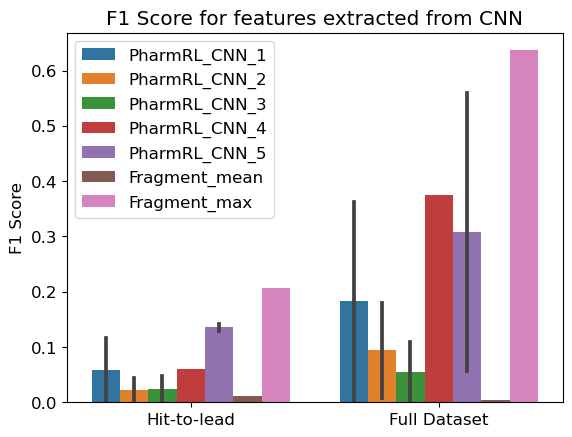

In [91]:
ax = sns.barplot(x="system", y="f1", hue="model", data=df_cnn)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score for features extracted from CNN')
ax.set(xlabel=None)

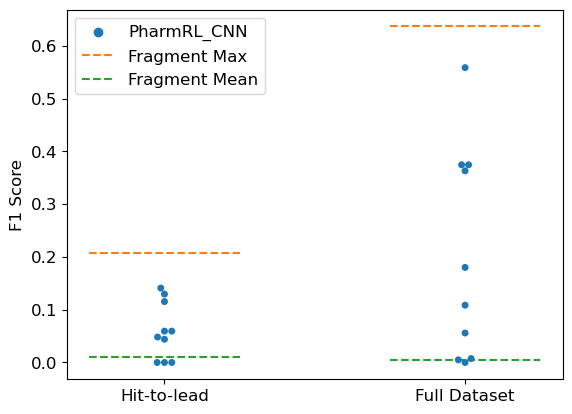

In [92]:
df_cnn.loc[df_cnn.model.str.contains('PharmRL_CNN'),'model']='PharmRL_CNN'
#df_cnn.loc[df_cnn.num_feats==3,'model']='PharmRL_CNN_3'
#ax=sns.boxplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn.model.str.contains('PharmRL_CNN')])
ax=sns.swarmplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn.model.str.contains('PharmRL_CNN')])

#ax=sns.boxplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn['model']=='Fragment_mean'])
#ax=sns.boxplot(x='system',y='f1',hue='model',data=df_cnn[df_cnn['model']=='Fragment_max'])
df_cnn_hit=df_cnn[df_cnn['system']=='Hit-to-lead']
df_cnn_full=df_cnn[df_cnn['system']=='Full Dataset']
#plot horizontal lines for mean and max for each system
ax.hlines(y=df_cnn_hit[df_cnn_hit['model']=='Fragment_max']['f1'],xmin=-0.25,xmax=0.25,linestyles='dashed',label='Fragment Max',color='#ff7f0e')
ax.hlines(y=df_cnn_full[df_cnn_full['model']=='Fragment_max']['f1'],xmin=0.75,xmax=1.25,linestyles='dashed',label='Fragment Max',color='#ff7f0e')
ax.hlines(y=df_cnn_hit[df_cnn_hit['model']=='Fragment_mean']['f1'],xmin=-0.25,xmax=0.25,linestyles='dashed',label='Fragment Mean',color='#2ca02c')
ax.hlines(y=df_cnn_full[df_cnn_full['model']=='Fragment_mean']['f1'],xmin=0.75,xmax=1.25,linestyles='dashed',label='Fragment Mean',color='#2ca02c')

#ax.hlines(y=df_cnn_hit[df_cnn_hit['model']=='Fragment_mean']['f1'],xmin=0,xmax=1,linestyles='dashed',label='Fragment Mean',color='red')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:2]+[handles[3]], labels=labels[:2]+[labels[3]])
ax.set_ylabel('F1 Score')
ax.set(xlabel=None)
plt.savefig('covid_f1_cnn.png',bbox_inches='tight')